In [1]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
from statistics import mean
from IPython.display import display, Latex
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 9,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

/Users/sharmila/anaconda3/envs/py36_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  app.launch_new_instance()


In [2]:
results_dir = os.path.join(os.getcwd(), 'results_metrics/')

In [3]:
def plot(kstest_stats, d_xi):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #plt.rcParams.update({'font.size': 9})
    
    width = 7.5/2
    height = width/1.6
    figure, ax = plt.subplots(figsize=(width, height)) #figsize=(8, 6)
    df = pd.DataFrame({'col':kstest_stats})
    y, x, _=plt.hist(kstest_stats, bins = 30) #, label='Histogram of relative error in ' + title
    #plt.grid(True)
    #plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel("KS test statistic of " + r'$\xi_{%.0f}$' % (d_xi+1))
    plt.ylabel("Count",rotation=0)
    ax.yaxis.set_label_coords(0.0, 1.05)
    sns.despine(trim=True)
    plt.tight_layout(pad=0.1)
    plt.savefig('hist_kstest_stats_parameter'+ str(d_xi+1) +'.pdf', dpi=300, bbox_inches='tight')
    plt.show()

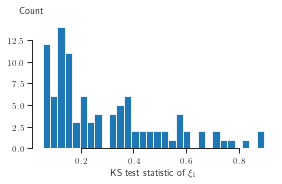

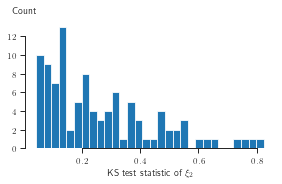

In [4]:
for d_xi in range(2):
    kstest_stats = []
    
    for j in range(100):
        xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
        xi_samples_MCMC = torch.load(results_dir +str(j)+'_MCMC'+'_xi_samples.pt')
        kstest_stat, _ = st.kstest(xi_samples_AVI[:,d_xi].detach().numpy(), xi_samples_MCMC[:,d_xi].detach().numpy())
        kstest_stats.append(kstest_stat)
    plot(kstest_stats, d_xi)    

In [5]:
from utilities3 import *
from networks import *

class EIT_fipy():
    """
    Class that solves forward electrostatic EIT BVP for different boundary conditions using fipy package for a circular damage.
    x_centers:  Location of the damage centers.
    """
    def __init__(self, x_centers):
        
        # defects with radius r=0.1 at x_centers
        self.x_centers = x_centers # (N x 2)

        self.Expts_description = {
                                'Expt-1': 'Unit current applied on all the sides',
                                'Expt-2': 'Unit current on left and right, no current on the other sides',
                                'Expt-3': 'Unit current on top and bottom, no current on the other sides'
                                }
        
            
    def forward_process_preds(self):
        
        u_preds_dict = {}
        
        for expt in self.Expts_description.keys():
        
            xc_normalizer = load_object('x_normalizer_'+expt+'.pkl')
            u_normalizer = load_object('y_normalizer_'+expt+'.pkl')

            x_centers_ = xc_normalizer.encode(self.x_centers)

            model_surrogate_state_dict = torch.load('model_state_dict_'+expt+'.pt')
            model_surrogate = DenseResNet(dim_in=x_centers_.shape[1], dim_out=200, num_resnet_blocks=5, 
                     num_layers_per_block=3, num_neurons=60, activation=nn.SiLU())
            model_surrogate.load_state_dict(model_surrogate_state_dict)

            u_preds_dict[expt] = u_normalizer.decode(model_surrogate(x_centers_))
        
        u_preds = torch.hstack((u_preds_dict['Expt-1'], u_preds_dict['Expt-2'], u_preds_dict['Expt-3']))
        return u_preds

In [6]:
xi_data, y_data = torch.load(results_dir +'xi_data.pt'), torch.load(results_dir +'y_data.pt')
xi_data.shape, y_data.shape

(torch.Size([100, 2]), torch.Size([100, 600]))

In [7]:
metric = 0
for j in range(100):
    
    xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
    diff = EIT_fipy(xi_samples_AVI).forward_process_preds() - EIT_fipy(xi_data[j].reshape(1,-1)).forward_process_preds()
    #print(diff.shape)
    
    metric += torch.linalg.norm(diff, 2, dim=1).mean()
    
print(metric/100)

tensor(0.0106, grad_fn=<DivBackward0>)
